# Predict unseen data

Using cache found in /home/white/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


#################################################################
Image


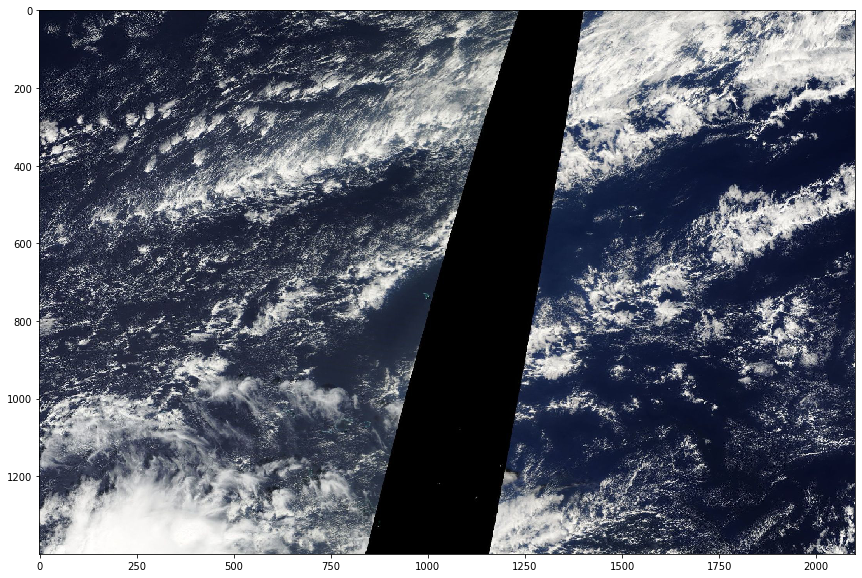

Fish


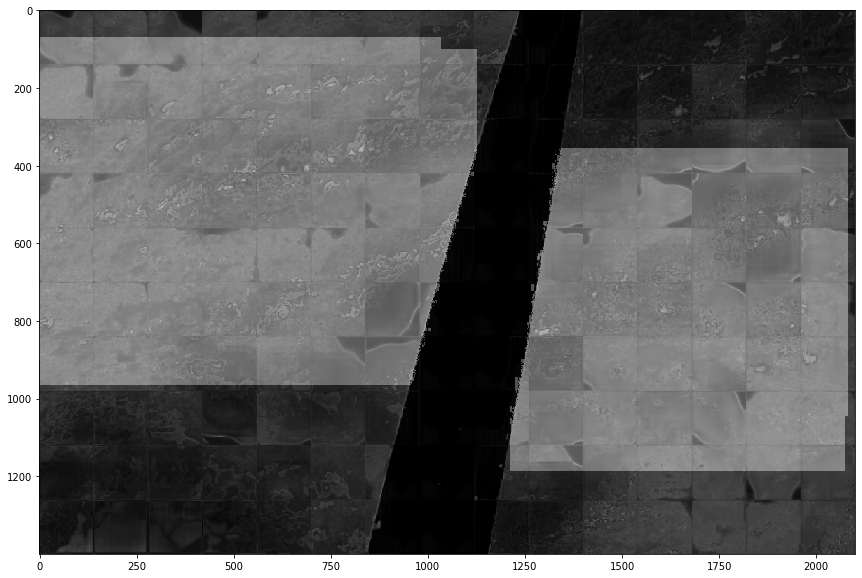

Flower


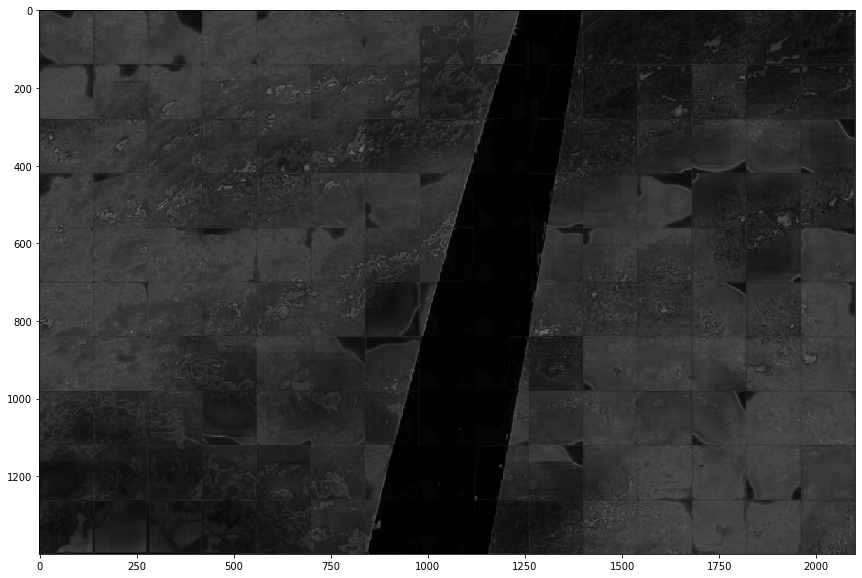

Gravel


In [ ]:
import torch
from aux import str_to_mask 
import matplotlib.pyplot as plt
from PIL import Image
from load import MyDataset
import numpy as np
from tqdm import tqdm

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size


SLICE_HEIGHT = 140
SLICE_WIDTH = 140


device = 'cpu'


model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=4, init_features=32)

model.load_state_dict(torch.load('model_01|23|2020--13:17:59/model_epoch_6_dict.pt', map_location=torch.device('cpu')))


model = model.to(device)
model.eval()

PREDICT_PATH = "../data/train_images/"
LABEL_PATH = "../data/train.csv"
TRAIN_PARTITION = 0.8

prediction_dataset = MyDataset(train_dir=PREDICT_PATH, labels=LABEL_PATH, train=False, train_partition=TRAIN_PARTITION, do_not_scale=True)


for sample, mask in prediction_dataset:
    blank_image = Image.new('RGB', (2100, 1400))
    blank_mask_Fish = Image.new('RGB', (2100, 1400))
    blank_mask_Flower = Image.new('RGB', (2100, 1400))
    blank_mask_Gravel = Image.new('RGB', (2100, 1400))
    blank_mask_Sugar = Image.new('RGB', (2100, 1400))
    
    blank_predicted_mask = Image.new('RGB', (2100, 1400))
    blank_predicted_mask_Flower = Image.new('RGB', (2100, 1400))
    blank_predicted_mask_Gravel = Image.new('RGB', (2100, 1400))
    blank_predicted_mask_Sugar = Image.new('RGB', (2100, 1400))
    
    
    
    sample = np.array(sample)
    mask = np.array(mask)

    
    max_value = np.max(sample)
    for i in tqdm(range(10)):
        for j in range(15):
            with torch.no_grad():
                row_pix = i * SLICE_HEIGHT
                col_pix = j * SLICE_WIDTH
                
                
                
                aux_img = sample[:, row_pix:row_pix + SLICE_HEIGHT, col_pix:col_pix + SLICE_WIDTH]

                aux_img = torch.Tensor(aux_img)
                aux_img = aux_img.to(device)
                aux_img = aux_img.unsqueeze(0) 
                aux_img = torch.nn.functional.interpolate(aux_img,size=(128,128), mode='nearest')
                aux_img = aux_img.squeeze(0)
                


                aux_mask = mask[:, row_pix:row_pix + SLICE_HEIGHT, col_pix:col_pix + SLICE_WIDTH]
                
               
                
                
                
                #downsample
                aux_mask = torch.Tensor(aux_mask)
                aux_mask = aux_mask.to(device)
                aux_mask = aux_mask.unsqueeze(0) 
                aux_mask = torch.nn.functional.interpolate(aux_mask,size=(128,128), mode='nearest')
                aux_mask = aux_mask.squeeze(0)
                
                
                aux_img = aux_img.unsqueeze(0)
                pred = model.forward(torch.Tensor(aux_img))
                
                
                #upsample image
                aux_img = torch.nn.functional.interpolate(aux_img,size=(140,140), mode='nearest')

                
                #upsample true mask
                aux_mask = aux_mask.unsqueeze(0) 
                aux_mask = torch.nn.functional.interpolate(aux_mask,size=(140,140), mode='nearest')
                aux_mask = aux_mask.squeeze(0)
                
                
                #upsample predicted
 
                pred = torch.nn.functional.interpolate(pred,size=(140,140), mode='nearest')
               
                
                
                pred = pred.squeeze(0)
                pred = pred.permute(1,2,0)
                pred = np.array(pred)
                aux_img = aux_img.squeeze(0)
                aux_img = aux_img.permute(1,2,0)
                
                aux_mask = aux_mask.permute(1,2,0)
                aux_img = np.array(aux_img).astype(np.float32)
                aux_img = (aux_img * 255 / max_value).astype('uint8')
                
                aux_mask = np.array(aux_mask).astype(np.float32)
                aux_mask = (aux_mask * 255 / 1.).astype('uint8')
                
                image = Image.fromarray(aux_img)
               
                

#                 pred[pred<0.3] = 0
                pred = pred * 255.
    
                pred_fish = Image.fromarray(pred[:,:,0])            
                pred_flower = Image.fromarray(pred[:,:,1])
                pred_gravel = Image.fromarray(pred[:,:,2])
                pred_sugar = Image.fromarray(pred[:,:,3])
                
#                 print('aux_mask', np.max(aux_mask))
                true_fish = Image.fromarray(aux_mask[:,:,0])
                true_flower = Image.fromarray(aux_mask[:,:,1])
                true_gravel = Image.fromarray(aux_mask[:,:,2])
                true_sugar = Image.fromarray(aux_mask[:,:,3])
                                                   
#                 blank_mask.paste(aux_mask,(col_pix, row_pix))
                blank_mask_Fish.paste(true_fish,(col_pix, row_pix))
                blank_mask_Flower.paste(true_flower,(col_pix, row_pix))
                blank_mask_Gravel.paste(true_gravel,(col_pix, row_pix))
                blank_mask_Sugar.paste(true_sugar,(col_pix, row_pix))
                                                   
                                                   
                blank_image.paste(image,(col_pix, row_pix))
                                                   
                blank_predicted_mask.paste(pred_fish,(col_pix, row_pix)) 
                blank_predicted_mask_Flower.paste(pred_flower,(col_pix,row_pix))
                blank_predicted_mask_Gravel.paste(pred_gravel,(col_pix,row_pix))
                blank_predicted_mask_Sugar.paste(pred_sugar,(col_pix,row_pix))
                                                   

    print('=================================================================')
    print('#################################################################')
    print('=================================================================')
    
    print('Image')
    plt.imshow(blank_image)
    plt.show()
    
    print('Fish')
    plt.imshow(blank_predicted_mask)
    plt.imshow(blank_mask_Fish,alpha=0.3)
    plt.show()
                                                   
    print('Flower')
    plt.imshow(blank_predicted_mask_Flower)
    plt.imshow(blank_mask_Flower, alpha=0.3)
    plt.show()
                                
    print('Gravel')                                              
    plt.imshow(blank_predicted_mask_Gravel)
    plt.imshow(blank_mask_Gravel, alpha=0.3)
    plt.show()
    print('Sugar')
    plt.imshow(blank_predicted_mask_Sugar)
    plt.imshow(blank_mask_Sugar, alpha=0.3)
    plt.show()
                                                   

